In [5]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_TYPE = 'dataset_2'
ARCHITECTURE = 'vgg'

Mounted at /content/drive


In [7]:
# downloading and extracting dataset images
!unzip /content/drive/MyDrive/Applied_AI_project/dataset_2.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset_2/late blight/LB_ (264).png  
  inflating: __MACOSX/dataset_2/late blight/._LB_ (264).png  
  inflating: dataset_2/late blight/e980207c-6e67-4caf-8973-7128ca2a1c12___GHLB2 Leaf 8876.JPG  
  inflating: __MACOSX/dataset_2/late blight/._e980207c-6e67-4caf-8973-7128ca2a1c12___GHLB2 Leaf 8876.JPG  
  inflating: dataset_2/late blight/953f355a-fd2c-433e-8292-a8c1908e000e___GHLB2 Leaf 8853.JPG  
  inflating: __MACOSX/dataset_2/late blight/._953f355a-fd2c-433e-8292-a8c1908e000e___GHLB2 Leaf 8853.JPG  
  inflating: dataset_2/late blight/tomato_D33a-Late-blight-015-OMAFHRT_zoom_jpg.rf.054f2a0a7ad993f4cf6e4372933cd5bc.jpg  
  inflating: __MACOSX/dataset_2/late blight/._tomato_D33a-Late-blight-015-OMAFHRT_zoom_jpg.rf.054f2a0a7ad993f4cf6e4372933cd5bc.jpg  
  inflating: dataset_2/late blight/0b52ebed-e711-41f2-bfd1-af73410b370e___RS_Late.B 5463_flipLR.JPG  
  inflating: __MACOSX/dataset_2/late blight/._0b52ebed-e711-41f2-bfd1-af7

In [8]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16

import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns

In [9]:
# splitting the dataset into specific folders for train, validate and test
!pip install split-folders

import splitfolders

source_folder = f'/content/{DATASET_TYPE}'
target_folder = f'/content/{DATASET_TYPE}_splitted'

train_ratio = .7
val_ratio = .15
test_ratio = .15

splitfolders.ratio(source_folder, output=target_folder, seed=1337, ratio=(train_ratio, val_ratio, test_ratio), group_prefix=None, move=False)

Copying files: 14658 files [00:03, 4243.44 files/s]


In [10]:
# applying data prepocessing and loading dataset
train_dataset_tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset_tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(f"/content/{DATASET_TYPE}_splitted/train", transform=train_dataset_tranform)
train_length = len(train_dataset)

validate_dataset = ImageFolder(f"/content/{DATASET_TYPE}_splitted/val", transform=test_dataset_tranform)
validate_length = len(validate_dataset)

test_dataset = ImageFolder(f"/content/{DATASET_TYPE}_splitted/test", transform=test_dataset_tranform)
test_dataset = len(test_dataset)

dataset_classes = train_dataset.classes
print(dataset_classes)

['early blight', 'healthy', 'late blight', 'mosaic virus', 'powdery mildew', 'septoria']


In [11]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

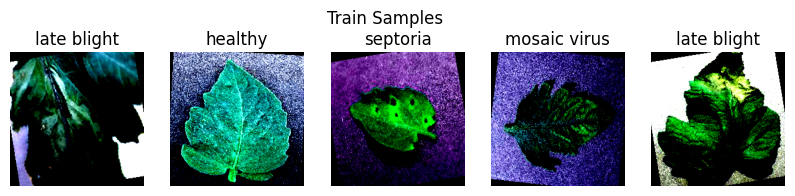

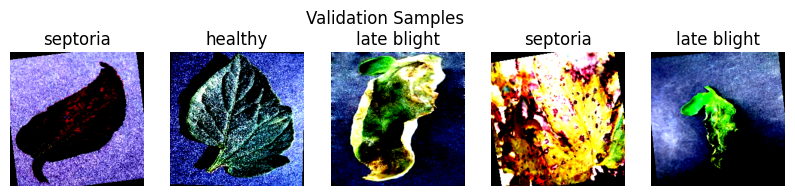

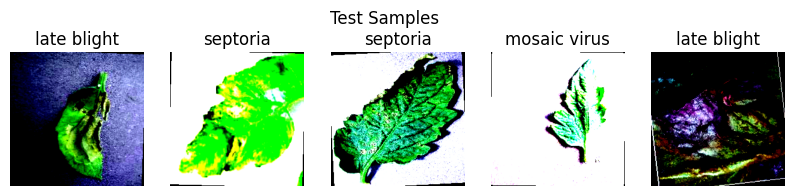

In [12]:
def show_images(loader, title):
    # Get a batch of images and labels from the loader
    images, labels = next(iter(loader))
    images = images.numpy()
    labels = labels.numpy()

    # Plot the images
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f'{dataset_classes[labels[i]]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display sample images from train loader
show_images(train_loader, 'Train Samples')

# Display sample images from validation loader
show_images(validate_loader, 'Validation Samples')

# Display sample images from test loader
show_images(test_loader, 'Test Samples')

In [13]:
# setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [14]:
# modifying architecture output classes
class VGG16(nn.Module):
  def __init__(self, num_of_classes):
    super(VGG16, self).__init__()
    self.model = vgg16(weights=None)
    features = self.model.classifier[-1].in_features
    self.model.classifier[-1] = nn.Linear(features, num_of_classes)

  def forward(self, x):
    x = self.model(x)
    return x

In [15]:
# defining model, optimizer, architecture
learning_rate = 0.001
epochs = 15

model = VGG16(num_of_classes=len(dataset_classes))
model = model.to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_function = CrossEntropyLoss()

print(model)

VGG16(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Ma

epoch number ---> 1 
training loss: 2.2166  training accuracy: 20.16 %
validation loss: 1.7428  validation accuracy: 19.66 %
best loss obtained: 1.7428
--model saved--
epoch number ---> 2 
training loss: 1.7432  training accuracy: 20.51 %
validation loss: 1.7421  validation accuracy: 20.81 %
best loss obtained: 1.7421
--model saved--
epoch number ---> 3 
training loss: 1.7427  training accuracy: 20.38 %
validation loss: 1.7418  validation accuracy: 21.24 %
best loss obtained: 1.7418
--model saved--
epoch number ---> 4 
training loss: 1.7423  training accuracy: 21.12 %
validation loss: 1.7397  validation accuracy: 21.24 %
best loss obtained: 1.7397
--model saved--
epoch number ---> 5 
training loss: 1.7419  training accuracy: 20.89 %
validation loss: 1.7407  validation accuracy: 20.81 %
epoch number ---> 6 
training loss: 1.7416  training accuracy: 20.87 %
validation loss: 1.7408  validation accuracy: 21.24 %
epoch number ---> 7 
training loss: 1.7409  training accuracy: 21.25 %
validat

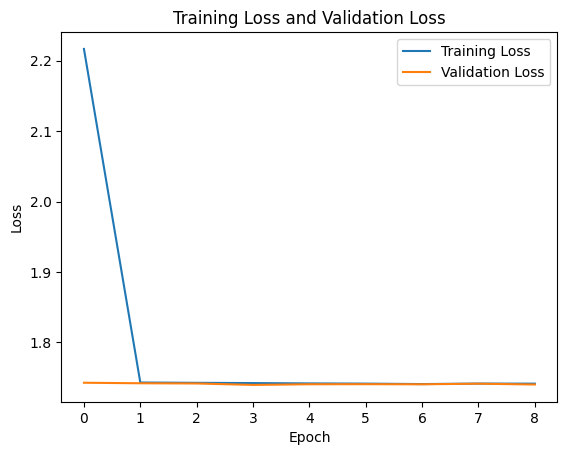

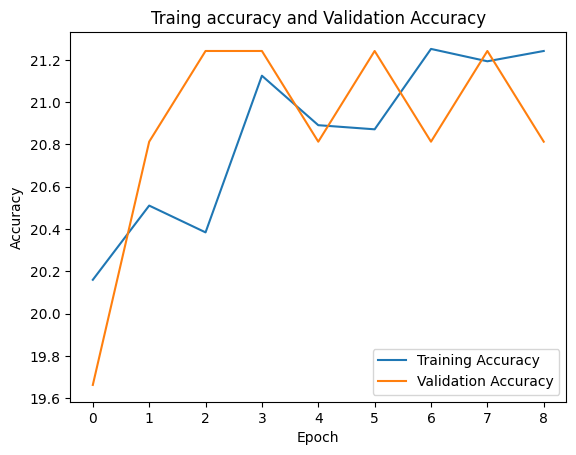

In [16]:
train_losses = []
train_accuracies = []
validate_losses = []
validate_accuracies = []
best_validate_loss = float('inf')
loss_wait_threshold = 5;
wait_counter = 0;

for epoch in range(epochs):

  print(f"epoch number ---> {epoch + 1} ")

  model.train()
  train_batch_loss = 0.0
  train_correct_predictions = 0
  train_samples = 0
  for xtrain, ytrain in train_loader:

    optimizer.zero_grad()

    xtrain = xtrain.to(device)
    ytrain = ytrain.to(device)
    train_prob = model(xtrain)

    # calculating batch accuracy
    _, train_prediction = torch.max(train_prob, 1)
    train_samples += ytrain.size(0)
    train_correct_predictions += (train_prediction == ytrain).sum().item()

    loss = loss_function(train_prob, ytrain)
    loss.backward()
    optimizer.step()

    # calculating batch loss
    train_batch_loss += loss.item()

  # calculating train loss for epoch
  train_loss = train_batch_loss / len(train_loader)
  train_losses.append(train_loss)

  # calculating train accuracy for epoch
  train_accuracy = 100 * (train_correct_predictions / train_samples)
  train_accuracies.append(train_accuracy)
  print("training loss: {:.4f}  training accuracy: {:.2f} %".format(train_loss, train_accuracy))

  validate_batch_loss = 0.0
  validate_correct_predictions = 0
  validate_samples = 0
  model.eval()
  with torch.no_grad():
    for xvalidate, yvalidate in validate_loader:

      optimizer.zero_grad()

      xvalidate = xvalidate.to(device)
      yvalidate = yvalidate.to(device)
      validate_prob = model(xvalidate)

      #calculating batch accuracy
      _, validate_prediction = torch.max(validate_prob, 1)
      validate_samples += yvalidate.size(0)
      validate_correct_predictions += (validate_prediction == yvalidate).sum().item()

      loss = loss_function(validate_prob, yvalidate)

      #calculating batch loss
      validate_batch_loss += loss.item()

  # calculating validate loss for epoch
  validate_loss = validate_batch_loss / len(validate_loader)
  validate_losses.append(validate_loss)

  # calculating validate accuracy for epoch
  validate_accuracy = 100 * (validate_correct_predictions / validate_samples)
  validate_accuracies.append(validate_accuracy)
  print("validation loss: {:.4f}  validation accuracy: {:.2f} %".format(validate_loss, validate_accuracy))

  if validate_loss < best_validate_loss:
    best_validate_loss = validate_loss
    print("best loss obtained: {:.4f}".format(best_validate_loss))
    torch.save(model.state_dict(), 'best_model_details.pth')
    print(f"--model saved--")
    wait_counter = 0
  else:
    wait_counter += 1
    if wait_counter >= loss_wait_threshold:
      print(f"loss variation exceeded threshold")
      break;

print(f"training and validation for {epochs} epochs completed")
print(f"train losses: {train_losses}")
print(f"train accuracies: {train_accuracies}")
print(f"validation losses: {validate_losses}")
print(f"validation accuracies: {validate_accuracies}")

# saving metrics to a file
np.savez(f'/content/{ARCHITECTURE}_{DATASET_TYPE}_metrics.npz',
         train_losses=train_losses,
         train_accuracies=train_accuracies,
         validate_losses=validate_losses,
         validate_accuracies=validate_accuracies)

plt.plot(train_losses, label='Training Loss')
plt.plot(validate_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validate_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Traing accuracy and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
#loading the saved model

best_model_values = torch.load('/content/best_model_details.pth')
model.load_state_dict(best_model_values)

total_samples = []
total_predictions = []

# testing the model againt test dataset
test_batch_loss = 0.0
test_correct_predictions = 0
test_samples = 0
model.eval()
with torch.no_grad():
  for xtest, ytest in test_loader:
    optimizer.zero_grad()

    xtest = xtest.to(device)
    ytest = ytest.to(device)
    test_prob = model(xtest)

    #calculating batch accuracy
    _, test_prediction = torch.max(test_prob, 1)

    total_samples.extend(ytest.cpu().numpy())
    total_predictions.extend(test_prediction.cpu().numpy())

    test_samples += ytest.size(0)
    test_correct_predictions += (test_prediction == ytest).sum().item()

    loss = loss_function(test_prob, ytest)

    #calculating batch loss
    test_batch_loss += loss.item()

  # calculating validate loss for epoch
  test_loss = test_batch_loss / len(test_loader)

  # calculating validate accuracy for epoch
  test_accuracy = 100 * (test_correct_predictions / test_samples)
  print("test loss: {:.4f}  test accuracy: {:.2f} %".format(test_loss, test_accuracy))

  # saving test metric to file
  np.savez(f'/content/{ARCHITECTURE}_{DATASET_TYPE}_testmetrics.npz',
         total_samples=total_samples,
         total_predictions=total_predictions,
         test_loss=[test_loss],
         test_accuracy=[test_accuracy])

test loss: 0.4009  test accuracy: 85.61 %


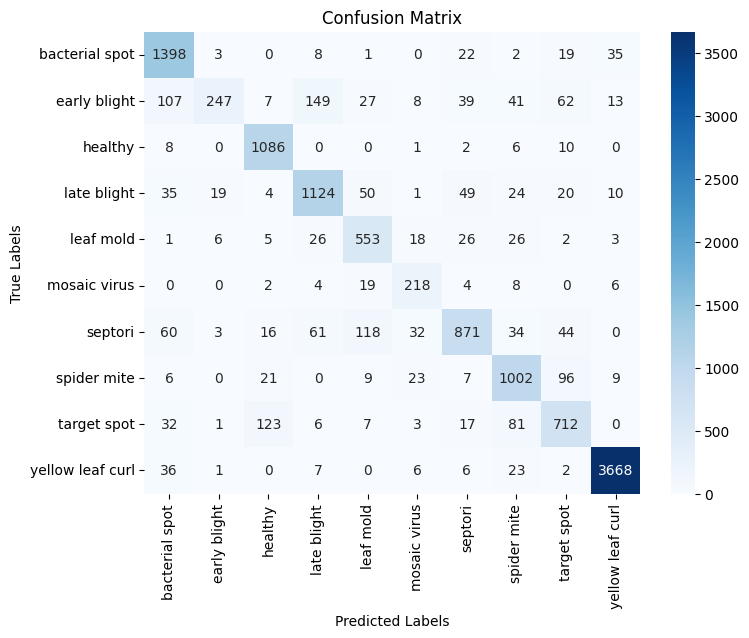

In [ ]:
# displaying confusion matrix
confusion_matrix = confusion_matrix(total_samples, total_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix,
            annot=True,
            cmap='Blues',
            fmt='g',
            xticklabels=dataset_classes,
            yticklabels=dataset_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Generate the classification report
print(classification_report(total_samples, total_predictions, target_names=dataset_classes))

                  precision    recall  f1-score   support

  bacterial spot       0.83      0.94      0.88      1488
    early blight       0.88      0.35      0.50       700
         healthy       0.86      0.98      0.91      1113
     late blight       0.81      0.84      0.83      1336
       leaf mold       0.71      0.83      0.76       666
    mosaic virus       0.70      0.84      0.76       261
         septori       0.84      0.70      0.76      1239
     spider mite       0.80      0.85      0.83      1173
     target spot       0.74      0.73      0.73       982
yellow leaf curl       0.98      0.98      0.98      3749

        accuracy                           0.86     12707
       macro avg       0.81      0.80      0.80     12707
    weighted avg       0.86      0.86      0.85     12707



In [ ]:
# calculating precision, recall, f1-score and accuracy

accuracy = accuracy_score(total_samples, total_predictions)
precision = precision_score(total_samples, total_predictions, average = 'weighted')
recall = recall_score(total_samples, total_predictions, average = 'weighted')
f1score = (2 * precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1score}")

Accuracy: 0.8561422837805934
Precision: 0.8594073405144398
Recall: 0.8561422837805934
F1-score: 0.8577717050979378
